# A2.5 Multilayer Neural Networks for Nonlinear Regression


Team members -

***Vishwajeet Bhosale*** 
              

## Summary

In this assignment you will 
* make some modifications to the supplied neural network implementation, 
* define a function that partitions data into training, validation and test sets,
* apply it to a data set, 
* define a function that runs experiments with a variety of parameter values, 
* describe your observations of these results.

## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.  You must complete the implementation of `adam`, following its implementation in the lecture notes.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
def printmd(string, color='Red'):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [3]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Finish Adam implementation here by updating
            #   self.mt
            #   self.vt
            #   self.beta1t
            #   self.beta2t
            # and updating values of self.all_weights
            
            self.mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(grad)
            
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2
            
            mhat = self.mt / (1 - self.beta1t )
            vhat = self.vt / (1 - self.beta2t )  
            
            self.all_weights -= alpha * mhat / (np.sqrt(vhat) + epsilon)

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                #print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')
                pass

        return error_trace

Test `Optimizers` using the function `test_optimizers`.  You should get the same results shown below.

In [4]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    
    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')
    

In [5]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

You must first complete the `use` function.  You can make use of the `forward_pass` function.

Then test it with the `test_neuralnetwork` function.  Your results should be the same as those shown, because the pseudo-random number generator used to initialize the weights is set to start with the same seed.

### See NeuralNetwork2 class below

In [7]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [8]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [9]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [108]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork2(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork2(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423



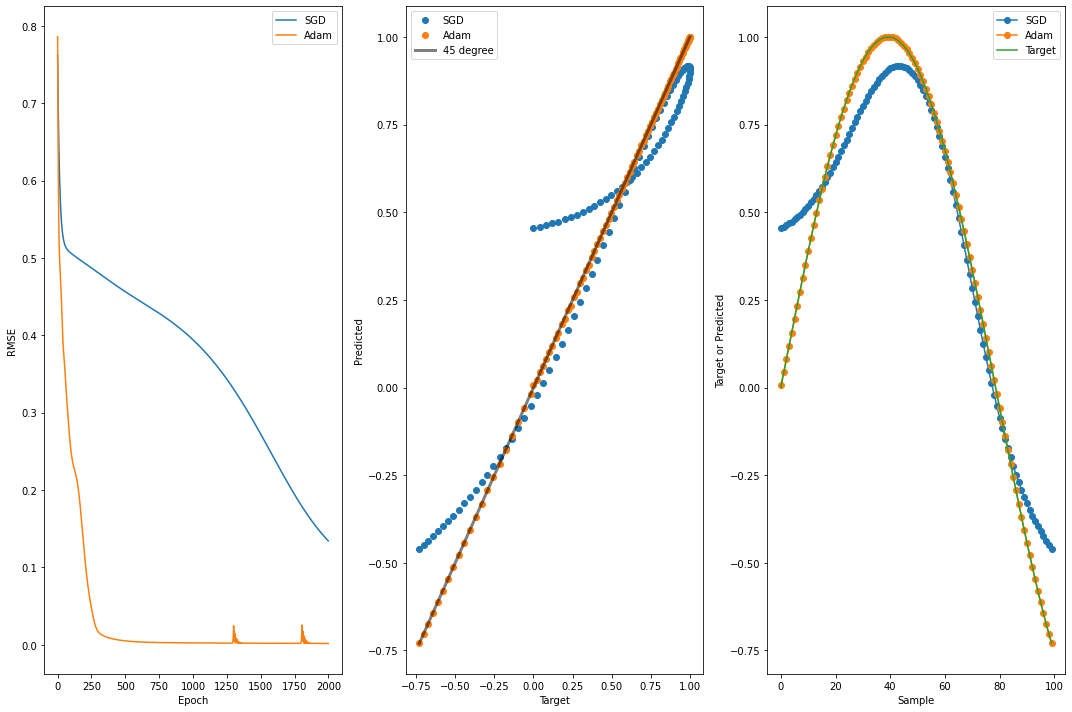

In [109]:
test_neuralnetwork()

## ReLU Activation Function

Cut and paste your `NeuralNetwork` class cell here.  Then modify it to allow the use of the ReLU activiation function, in addition to the `tanh` activation function that `NeuralNetwork` currently uses.  

Do this by
* Add the argument `activation_function` to the `NeuralNetwork` constructor that can be given values of `tanh` or `relu`, with `tanh` being its default value.
* Define two new class functions, `relu(s)` that accepts a matrix of weighted sums and returns the ReLU values, and `grad_relu(s)` that returns the gradient of `relu(s)` with respect to each value in `s`.
* Add `if` statements to `forward_pass` and `gradient_f` to selectively use the `tanh` or `relu` activation function. This is easy if you assign a new class variable in the `NeuralNetwork` constructor that has the value of the argument `activation_function`.

 ## Making new class `NeuralNetwork2` for ReLU and Swish implementaion

In [114]:
class NeuralNetwork2():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # ----- Added a class variable to hold the value of selected activation function
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        
        if self.activation_function == "tanh":
            for W in self.Ws[:-1]:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            last_W = self.Ws[-1]
            self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
            
        elif  self.activation_function == "relu":
            for W in self.Ws[:-1]:
                weighted_sum = self.Ys[-1] @ W[1:, :] + W[0:1, :]
                #print(weighted_sum)
                self.Ys.append(self.relu(weighted_sum))
                
            last_W = self.Ws[-1]
            self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
            
        elif self.activation_function == 'swish':
            for W in self.Ws[:-1]:
                weighted_sum = self.Ys[-1] @ W[1:, :] + W[0:1, :]
                #print(weighted_sum)
                self.Ys.append(self.swish(weighted_sum))
                
            last_W = self.Ws[-1]
            self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
            
        
        
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        
        if self.activation_function == 'tanh':
            
            # Step backwards through the layers to back-propagate the error (delta)
            for layeri in range(n_layers - 1, -1, -1):
                # gradient of all but bias weights
                self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
                # gradient of just the bias weights
                self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
                # Back-propagate this layer's delta to previous layer
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
                
                
        elif self.activation_function == 'relu':
            
            for layeri in range(n_layers - 1, -1, -1):
                # gradient of all but bias weights
                self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
                # gradient of just the bias weights
                self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
                # Back-propagate this layer's delta to previous layer
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri]) #(1 - self.Ys[layeri] ** 2)
        
        elif self.activation_function == 'swish':
            
            for layeri in range(n_layers - 1, -1, -1):
                # gradient of all but bias weights
                self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
                # gradient of just the bias weights
                self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
                # Back-propagate this layer's delta to previous layer
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_swish(self.Ys[layeri]) #(1 - self.Ys[layeri] ** 2)
            
            
        return self.all_gradients

    
    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''

        X = (X - self.Xmeans) / self.Xstds
        pred = self.forward_pass(X)[-1]
        
        unstd_pred = (pred * self.Tstds) + self.Tmeans
        
        return unstd_pred
    
    
    def relu(self, WS):
        
        relu_val = np.maximum(0.0,WS)
        
        return relu_val
    
    
    def grad_relu(self, WB):
        
        WB_mod = WB.copy()
        
        WB_mod[WB<=0] = 0
        WB_mod[WB>0] = 1
        
        return WB_mod
    
    
    def swish(self, WM):
        
        swish_val = WM/(1+np.exp(-WM))
        
        return swish_val
    
    
    def grad_swish(self, WSB):
        
        WSB_mod = WSB.copy()
        
        WSB_mod = self.swish(WSB_mod) + ((1/(1+np.exp(-WSB))) * ( 1 - self.swish(WSB_mod)))
        
        return WSB_mod                 
                                        

 ### Making function `test_neuralnetwork2` to get results with ReLU activation function

In [13]:
def test_neuralnetwork2():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork2(1, n_hiddens, 1, activation_function = 'relu')
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork2(1, n_hiddens, 1, activation_function = 'relu')
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.40411
sgd: Epoch 400 Error=0.32432
sgd: Epoch 600 Error=0.28213
sgd: Epoch 800 Error=0.25733
sgd: Epoch 1000 Error=0.23891
sgd: Epoch 1200 Error=0.22271
sgd: Epoch 1400 Error=0.20748
sgd: Epoch 1600 Error=0.19200
sgd: Epoch 1800 Error=0.17596
sgd: Epoch 2000 Error=0.16013



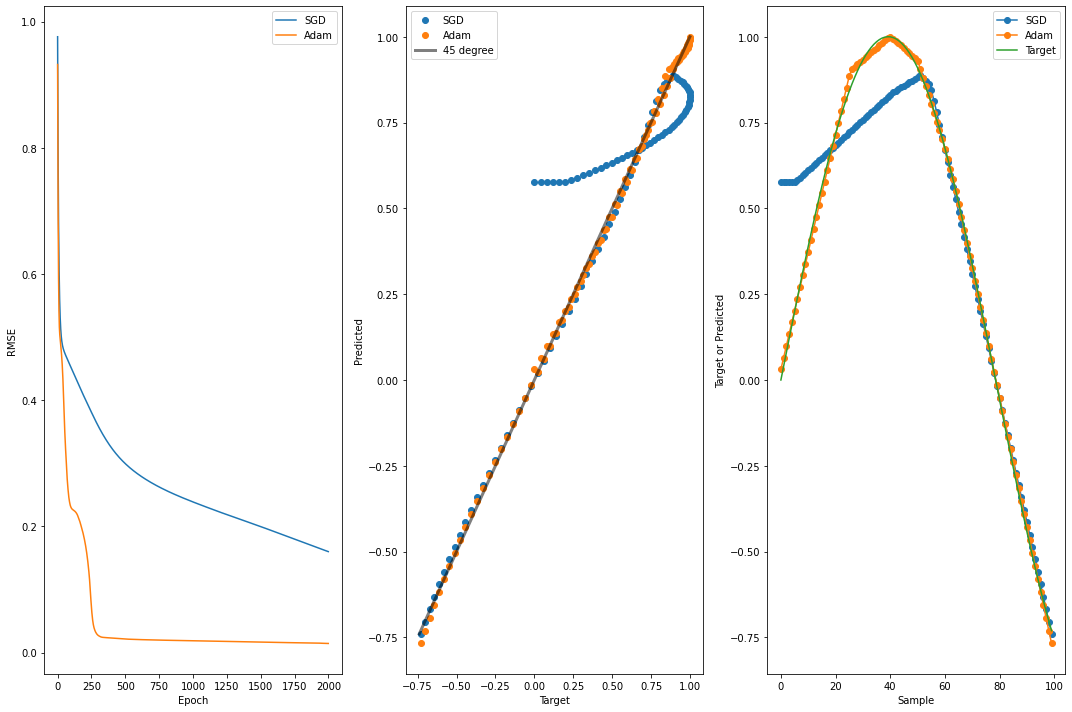

In [110]:
test_neuralnetwork2()

## Now for the Experiments!

Now that your code is working, let's apply it to some interesting data.

Read in the `auto-mpg.data` that we have used in lectures.  Let's apply neural networks to predict `mpg` using various neural network architectures, numbers of epochs, and our two activation functions.

This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [15]:
import pandas as pd
np.random.seed(42)

In [16]:
def partition(X_copy, T_copy, num_folds, random_shuffle=True):
    
    X = X_copy.copy()
    T = T_copy.copy()
    
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)  
    
    X = X[rows, :]
    T = T[rows, :]

    n_folds = num_folds
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds 
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )   
    len(folds), len(folds[0]), folds[0][0].shape, folds[0][1].shape
    
    print(folds[0][1].shape)

    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]]) 
    Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape
    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

 ### Importing auto-mpg data from stored file

In [120]:
data_df = pd.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, na_values='?')
data_df = data_df.dropna()
data_df.shape

data_df.columns

data = data_df.iloc[:, :-1].values

X = data[:, 1:]
T = data[:, 0:1]

Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, num_folds = 5)

#Xtest.shape

(78, 1)


Write a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, create and train a neural network using the 'adam' optimization method and use the neural network on the training, validation and test sets.  Collect the parameter values and the RMSE for the training, validation, and test set in a list.  When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
Your function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, your `run_experiment` function must first call your `partition` function to form the training, validation and test sets.

In [118]:
def run_experiment(Xval, Tval,n_folds, n_epochs_choices, n_hidden_units_per_layer_choices, activation_function_choices):
    
    learning_rate = 0.01
    
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(Xval, Tval, num_folds = n_folds)
    
    num_inputs = Xtrain.shape[1]
    num_output = Ttrain.shape[1]
    
    
    result_list = []
    
   
    for act_func in activation_function_choices:
       
        for n_epochs in n_epochs_choices:
        
            for n_hidden in n_hidden_units_per_layer_choices:
                
                nnetadam = NeuralNetwork2(num_inputs, n_hidden, num_output, activation_function = act_func)
                nnetadam.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam')
                

                #RMSE train
                Yadam_train = nnetadam.use(Xtrain)
                rmse_val_train = (np.sqrt(((Yadam_train - Ttrain) ** 2).mean())) 
                
                #RMSE validation
                Yadam_val = nnetadam.use(Xvalidate)
                rmse_val_val = (np.sqrt(((Yadam_val - Tvalidate) ** 2).mean())) 
                
                #RMSE test
                Yadam_test = nnetadam.use(Xtest)
                rmse_val_test = (np.sqrt(((Yadam_test - Ttest) ** 2).mean())) 
                
                print(f'{n_epochs} - {n_hidden} - {act_func} = {rmse_val_train}')
                
                result_list.append((n_epochs, n_hidden, learning_rate, act_func, rmse_val_train, rmse_val_val, rmse_val_test))
                

                    
    
    result_df = pd.DataFrame(result_list, columns=['n_epochs', 'n_hidden', 'lr_rate', 'act_func', 'RMSE Train', 'RMSE val', 'RMSE Test'])
    
  
    return result_df

    

An example call of your function would look like this:

In [119]:
result_df = run_experiment(X, T, n_folds=5, 
                           n_epochs_choices=[1000, 2000, 5000, 20000],
                           n_hidden_units_per_layer_choices=[[0], [10], [20, 20], [50,25] , [20,50] ,[100,50], [20, 20, 20], [30,30,30,30]],
                           activation_function_choices=['tanh', 'relu'])



(78, 1)
1000 - [0] - tanh = 3.3632795636808512
1000 - [10] - tanh = 2.0869666673656933
1000 - [20, 20] - tanh = 1.4384948216354352
1000 - [50, 25] - tanh = 1.1350793268128152
1000 - [20, 50] - tanh = 1.5985168607488196
1000 - [100, 50] - tanh = 0.7039418883689006
1000 - [20, 20, 20] - tanh = 1.2100221270974143
1000 - [30, 30, 30, 30] - tanh = 1.4434375296922561
2000 - [0] - tanh = 3.36118540742115
2000 - [10] - tanh = 1.6772625798843757
2000 - [20, 20] - tanh = 0.9035026806904551
2000 - [50, 25] - tanh = 0.4387773959699063
2000 - [20, 50] - tanh = 0.5935399476521062
2000 - [100, 50] - tanh = 0.3284365112827992
2000 - [20, 20, 20] - tanh = 0.4738565409572185
2000 - [30, 30, 30, 30] - tanh = 0.3983524291828742
5000 - [0] - tanh = 3.3611854074210816
5000 - [10] - tanh = 1.527844512421268
5000 - [20, 20] - tanh = 0.1633489835738971
5000 - [50, 25] - tanh = 0.05110718287592757
5000 - [20, 50] - tanh = 0.09505815895186068
5000 - [100, 50] - tanh = 0.016609052780454228
5000 - [20, 20, 20] - t

,n_epochs,n_hidden,lr_rate,act_func,RMSE Train,RMSE val,RMSE Test
0,1000,[0],0.01,tanh,3.363280,3.094685,3.463916
1,1000,[10],0.01,tanh,2.086967,2.664505,3.151097
2,1000,"[20, 20]",0.01,tanh,1.438495,2.540530,3.172849
3,1000,"[50, 25]",0.01,tanh,1.135079,2.961414,3.476191
4,1000,"[20, 50]",0.01,tanh,1.598517,2.706307,3.026011
...,...,...,...,...,...,...,...
59,20000,"[50, 25]",0.01,relu,0.168171,3.519486,3.675665
60,20000,"[20, 50]",0.01,relu,0.184269,4.295644,4.611679
61,20000,"[100, 50]",0.01,relu,0.366254,3.569413,4.206890
62,20000,"[20, 20, 20]",0.01,relu,0.228232,3.697019,4.357945


In [121]:
result_df.sort_values('RMSE val')

,n_epochs,n_hidden,lr_rate,act_func,RMSE Train,RMSE val,RMSE Test
35,1000,"[50, 25]",0.01,relu,1.821863,2.446833,3.047278
33,1000,[10],0.01,relu,2.196376,2.487616,3.065492
55,5000,"[30, 30, 30, 30]",0.01,relu,1.827952,2.519610,2.969353
37,1000,"[100, 50]",0.01,relu,1.989123,2.528155,2.817291
2,1000,"[20, 20]",0.01,tanh,1.438495,2.540530,3.172849
...,...,...,...,...,...,...,...
60,20000,"[20, 50]",0.01,relu,0.184269,4.295644,4.611679
13,2000,"[100, 50]",0.01,tanh,0.328437,4.495175,4.322503
26,20000,"[20, 20]",0.01,tanh,0.134471,4.598845,4.813828
58,20000,"[20, 20]",0.01,relu,0.259054,4.786629,5.406744


In [92]:
min_validation_value = result_df['RMSE val'].idxmin()

#print(f"Lowest value of RMSE val is min_validation_value

val_result = result_df.iloc[min_validation_value]

val_result

n_epochs          1000
n_hidden      [50, 25]
lr_rate           0.01
act_func          tanh
RMSE Train     1.00505
RMSE val       2.65454
RMSE Test       4.1461
Name: 3, dtype: object

Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is - 


### Printing Lowest validation RMSE and its corresponding `RMSE Test`

In [103]:
print("\n")
print(f" ---- We get the lowest RMSE validation value of : {val_result['RMSE val']} with corresponding RMSE test value being : {val_result['RMSE Test']} -----")
print("\n")



 ---- We get the lowest RMSE validation value of : 2.6545447546159604 with corresponding RMSE test value being : 4.14609897478786 -----




 ### In Notebook-3 from class, we got RMSE of 3.45 using linear regression on the same data. Here, we get RMSE of 2.65 by using nonlinear activation functions and neural network with hidden layers. It is an improvement from linear regression but not a huge one. 
 
 ### Maybe if we had data with more nonlinear relationship, we would have benefitted by using Neural Networks (with nonlinea hidden layers)

Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`. 

(0.0, 8.0)

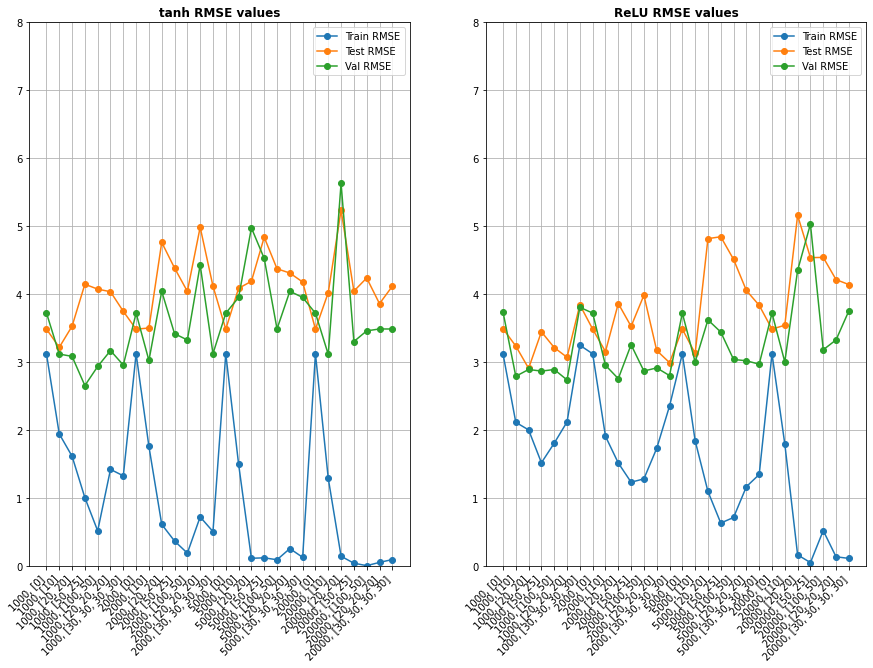

In [116]:
tanh_rows_df = result_df.loc[result_df['act_func'] == 'tanh']
relu_rows_df = result_df.loc[result_df['act_func'] == 'relu']

xval = [*(range(tanh_rows_df.shape[0]))]


plt.figure(figsize=(15,10))
plt.tight_layout()



plt.subplot(1,2,1)
plt.plot(xval, tanh_rows_df['RMSE Train'], 'o-', label= 'Train RMSE')
plt.plot(xval, tanh_rows_df['RMSE Test'], 'o-', label = 'Test RMSE')
plt.plot(xval, tanh_rows_df['RMSE val'], 'o-', label = 'Val RMSE')
xticks = tanh_rows_df[['n_epochs', 'n_hidden']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=45, ha='right')
plt.legend()
plt.title("tanh RMSE values", fontweight="bold")
plt.grid()
plt.ylim(0,8)

plt.subplot(1,2,2)
plt.plot(xval, relu_rows_df['RMSE Train'], 'o-', label= 'Train RMSE')
plt.plot(xval, relu_rows_df['RMSE Test'], 'o-', label = 'Test RMSE')
plt.plot(xval, relu_rows_df['RMSE val'], 'o-', label = 'Val RMSE')
xticks = relu_rows_df[['n_epochs', 'n_hidden']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=45, ha='right')
plt.legend()
plt.title("ReLU RMSE values", fontweight="bold")
plt.grid()
plt.ylim(0,8)


### <font color='darkblue'>Observations -</font> 

1. In both `tanh` and `ReLU`, as we increase the number of nonlinear hidden layers and the number of neurons per layer, we see less and less training RMSE. The testing and validation RMSE, on the other hand, seem to increase slightly with increase in number of neurons and hidden layers (after a point). This indicates that we might be overfitting our model to the training data by increasing the nonlinearity more than what is required. As we have seen in notebook-03, the relationship of mpg with other input variables is only slightly nonlinear. Therefore, the excess nonlinearity might be the reason for overfitiing


2. We get the best (near 1) validation RMSE to train RMSE ratio with one or two hidden layers (at max 3). This is in line with my ***observation-1*** . As we have only slightly nonlinear relationship between input variables and ***mpg***, one or two hidden layers might be enough to take care of that without overfitting


3. We observed a lot of variation in RMSE values everytime we shuffled the data by running `partition()`. Sometimes, tanh produced the lowest RMSE and sometimes ReLU. However, their respective lowest RMSE values were very close to each other (in the range of 0.5 - 0.9)


4. We got RMSE value near 8 with ReLU for some of the runs. This was not observed in tanh

## Grading and Check-in

You and your partner will score of 70 points if your functions are defined correctly. You can test this grading process yourself by downloading [A2grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A2grader.zip) and extract `A2grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 70/70.  The remaining 30 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [122]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Bhosale_A2-Copy1.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_sgd = opt.sgd(cubic, grad_cubic, [wmin], 100, 0.01)

sgd: Epoch 10 Error=0.11889
sgd: Epoch 20 Error=0.11092
sgd: Epoch 30 Error=0.10176
sgd: Epoch 40 Error=0.09162
sgd: Epoch 50 Error=0.08081
sgd: Epoch 60 Error=0.06972
sgd: Epoch 70 Error=0.05879
sgd: Epoch 80 Error=0.04844
sgd: Epoch 90 Error=0.03901
sgd: Epoch 100 Error=0.03072

--- 10/10 points. Returned correct value.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] 

In [28]:
import os
os.getcwd()

'/s/chopin/k/grad/anfanger/courses/cs445/as2'

Name this notebook as `Lastname1-Lastname2-A2.ipynb`| with Lastname1 being then name of the last name of the person who is turning in the notebook.

A different but similar grading script will be used to grade your checked-in notebook.  It will include different tests.

## Extra Credit: 5 point

Add the Swish activation function as a third choice in your `train` function in your `NeuralNetwork` class.
A little googling will find definitions of it and its gradient.  Start with [this article](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions).

Use your `run_experiment` function to compare results for all three activation functions.  Discuss the results.

## <font color='darkblue'>Swish Implementation -</font> 

<br>

1. We implemented swish using `swish(s)` and `grad_swish(s)` functions in the <font color='brown'>***NeuralNetwork2*** </font>  class


2. swish(x) is calculated as :- &emsp;   `x/(1+np.exp(-x))`  &emsp; <font color='brown'>***or*** </font>   &emsp; `x * sigmoid(x)`


3. gradient of swish is calculated as :-  &ensp;  `y + (sigmoid(x) * ( 1 - y))` \
      &emsp;  &emsp; where -  &ensp; `y = swish(x)`

 ### 1. Loading the data again to avoid conflict

In [29]:
data_df = pd.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, na_values='?')
data_df = data_df.dropna()
data_df.shape

data_df.columns

data = data_df.iloc[:, :-1].values

X = data[:, 1:]
T = data[:, 0:1]

Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, num_folds = 5)

#Xtest.shape

(78, 1)


 ### 2. Running run_experiment with swish,tanh and relu to get results

In [87]:
result_df = run_experiment(X, T, n_folds=5, 
                           n_epochs_choices=[1000, 2000, 5000, 20000],
                           n_hidden_units_per_layer_choices=[[0], [10], [20, 20], [50,25], [100,50], [20, 20, 20], [30,30,30,30]],
                           activation_function_choices=['tanh', 'relu', 'swish'])

result_df


(78, 1)


/usr/local/python-env/py36/lib/python3.6/site-packages/ipykernel_launcher.py:231: RuntimeWarning: overflow encountered in exp


,n_epochs,n_hidden,lr_rate,act_func,RMSE Train,RMSE val,RMSE Test
0,1000,[0],0.01,tanh,3.122417,3.724246,3.486118
1,1000,[10],0.01,tanh,1.943491,3.118211,3.217379
2,1000,"[20, 20]",0.01,tanh,1.614514,3.084111,3.528069
3,1000,"[50, 25]",0.01,tanh,1.005048,2.654545,4.146099
4,1000,"[100, 50]",0.01,tanh,0.516378,2.935556,4.073792
...,...,...,...,...,...,...,...
79,20000,"[20, 20]",0.01,swish,1.053127,5.552328,6.024576
80,20000,"[50, 25]",0.01,swish,0.722249,17.158646,28.113209
81,20000,"[100, 50]",0.01,swish,0.320112,6.096171,7.131815
82,20000,"[20, 20, 20]",0.01,swish,2.070671,3.091581,3.271549


 ### 3. Selecting Min. RMSE and the parameters associated with it for each activation function

In [88]:
min_validation_value_tanh = tanh_rows_df['RMSE val'].idxmin()
min_validation_value_relu = relu_rows_df['RMSE val'].idxmin()
min_validation_value_swish = swish_rows_df['RMSE val'].idxmin()

#print(f"Lowest value of RMSE val is min_validation_value

val_result_tanh = result_df.iloc[min_validation_value_tanh]
val_result_relu = result_df.iloc[min_validation_value_relu]
val_result_swish = result_df.iloc[min_validation_value_swish]

print(f'\n----- Min. RMSE for tanh ------ \n\n{val_result_tanh} \n--------------------------------')
print('\n')
print(f'----- Min. RMSE for relu ------ \n\n{val_result_relu} \n--------------------------------')
print('\n')
print(f'----- Min. RMSE for swish ------ \n\n{val_result_swish} \n--------------------------------')


----- Min. RMSE for tanh ------ 

n_epochs         1000
n_hidden         [10]
lr_rate          0.01
act_func         tanh
RMSE Train    1.94349
RMSE val      3.11821
RMSE Test     3.21738
Name: 1, dtype: object 
--------------------------------


----- Min. RMSE for relu ------ 

n_epochs                  2000
n_hidden      [30, 30, 30, 30]
lr_rate                   0.01
act_func                  relu
RMSE Train             2.35222
RMSE val               2.80168
RMSE Test              2.99202
Name: 41, dtype: object 
--------------------------------


----- Min. RMSE for swish ------ 

n_epochs              2000
n_hidden      [20, 20, 20]
lr_rate               0.01
act_func             swish
RMSE Train          1.7788
RMSE val           2.92188
RMSE Test          3.62333
Name: 68, dtype: object 
--------------------------------


 ### 4. Plotting train, test and validation RMSE for each activation function

(0.0, 8.0)

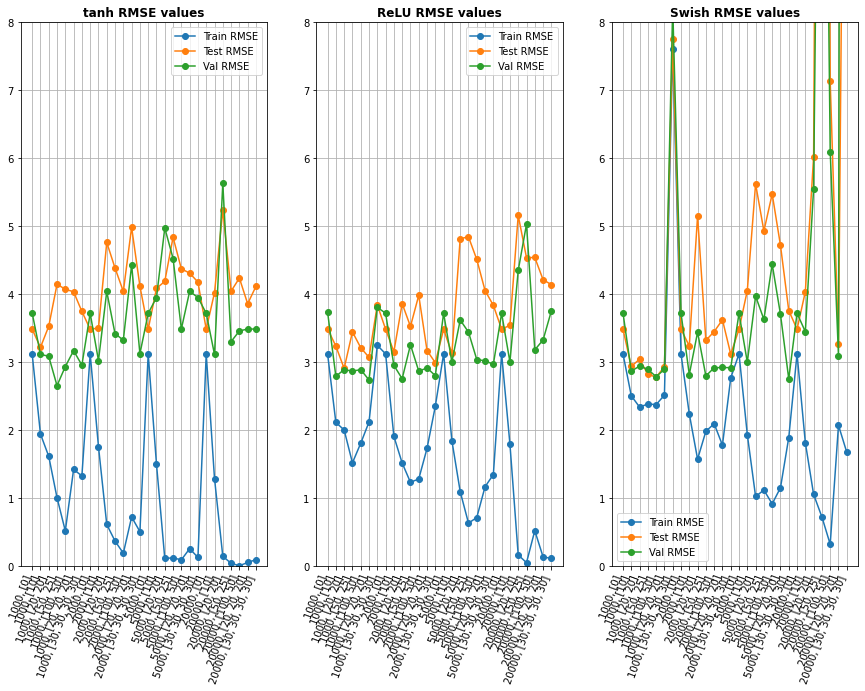

In [89]:
tanh_rows_df = result_df.loc[result_df['act_func'] == 'tanh']
relu_rows_df = result_df.loc[result_df['act_func'] == 'relu']
swish_rows_df = result_df.loc[result_df['act_func'] == 'swish']

xval = [*(range(tanh_rows_df.shape[0]))]


plt.figure(figsize=(15,10))
plt.tight_layout()



plt.subplot(1,3,1)
plt.plot(xval, tanh_rows_df['RMSE Train'], 'o-', label= 'Train RMSE')
plt.plot(xval, tanh_rows_df['RMSE Test'], 'o-', label = 'Test RMSE')
plt.plot(xval, tanh_rows_df['RMSE val'], 'o-', label = 'Val RMSE')
xticks = tanh_rows_df[['n_epochs', 'n_hidden']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=70, ha='right')
plt.legend()
plt.title("tanh RMSE values", fontweight="bold")
plt.grid()
plt.ylim(0,8)

plt.subplot(1,3,2)
plt.plot(xval, relu_rows_df['RMSE Train'], 'o-', label= 'Train RMSE')
plt.plot(xval, relu_rows_df['RMSE Test'], 'o-', label = 'Test RMSE')
plt.plot(xval, relu_rows_df['RMSE val'], 'o-', label = 'Val RMSE')
xticks = relu_rows_df[['n_epochs', 'n_hidden']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=70, ha='right')
plt.legend()
plt.title("ReLU RMSE values", fontweight="bold")
plt.grid()
plt.ylim(0,8)

plt.subplot(1,3,3)
plt.plot(xval, swish_rows_df['RMSE Train'], 'o-', label= 'Train RMSE')
plt.plot(xval, swish_rows_df['RMSE Test'], 'o-', label = 'Test RMSE')
plt.plot(xval, swish_rows_df['RMSE val'], 'o-', label = 'Val RMSE')
xticks = swish_rows_df[['n_epochs', 'n_hidden']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=70, ha='right')
plt.legend()
plt.title("Swish RMSE values", fontweight="bold")
plt.grid()
plt.ylim(0,8)


### <font color='darkblue'>Observations -</font> 

1. For some runs, Swish activation function very large RMSE values (around 50) for some of the configurations of hyperparameters. Especially, when number of epochs and number of hidden layers were large. This is surprising as swish is bounded for large negative values and has smooth curve compared to ReLu

2. We observed lowest RMSE when using either Swish or ReLU


### <font color='darkblue'>References --</font> 
[1]https://sefiks.com/2018/08/21/swish-as-neural-networks-activation-function/
<br>
[2]https://towardsdatascience.com/swish-booting-relu-from-the-activation-function-throne-78f87e5ab6eb